<a href="https://colab.research.google.com/github/cheepi/analisis-serangan-siber/blob/main/analisis_serangan_siber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis Serangan Siber Harian**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, pearsonr

## **Import & Cleaning Data**

In [ ]:
url = "https://docs.google.com/spreadsheets/d/1OMMIxN9VJ5RRyg2pBopFbxU8VnN1mNi_Rh8CeFxddew/gviz/tq?tqx=out:csv&sheet=count%20of%20attacks%20per%20day"
df_attacks_per_day = pd.read_csv(url)

# overview df
print('Dimensi dataframe: ', df_attacks_per_day.shape)
print('\nBaris awal data: ')
print(df_attacks_per_day.head())
print('\nTipe data dan missing vals: ')
print(df_attacks_per_day.info())

# rename kolom gar mudah diakses
df_attacks_per_day.columns = ['Tanggal', 'jumlah', 'unused1', 'unused2']

# ambil kolom penting + drop NaN
df_attacks_per_day_cleaned = df_attacks_per_day[['Tanggal', 'jumlah']].copy()
df_attacks_per_day_cleaned = df_attacks_per_day_cleaned[df_attacks_per_day_cleaned['jumlah'].notna()]

# ubah tipe data
df_attacks_per_day_cleaned['jumlah'] = pd.to_numeric(df_attacks_per_day_cleaned['jumlah'], errors='coerce')
df_attacks_per_day_cleaned['Tanggal'] = pd.to_datetime(df_attacks_per_day_cleaned['Tanggal'])

print('\nDimensi baru df:', df_attacks_per_day_cleaned.shape)
print('Preview cleaned df:')
print(df_attacks_per_day_cleaned.head())

Dimensi dataframe:  (1380, 4)

Baris awal data: 
  Timestamp  count Timestamp  Unnamed: 2  Unnamed: 3
0  1/1/2020               30         NaN         NaN
1  1/2/2020               24         NaN   28.985507
2  1/3/2020               32         NaN         NaN
3  1/4/2020               24         NaN   29.000000
4  1/5/2020               24         NaN         NaN

Tipe data dan missing vals: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Timestamp        1380 non-null   object 
 1   count Timestamp  1380 non-null   int64  
 2   Unnamed: 2       0 non-null      float64
 3   Unnamed: 3       5 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 43.3+ KB
None

Dimensi baru df: (1380, 2)
Preview cleaned df:
     Tanggal  jumlah
0 2020-01-01      30
1 2020-01-02      24
2 2020-01-03      32
3 2020-01-04      24


## **Statistik Deskriptif**

In [ ]:
statistik_deskriptif_jumlah = df_attacks_per_day_cleaned['jumlah'].describe()
print("Statistik Deskriptif Jumlah Serangan Harian:\n", statistik_deskriptif_jumlah, "\n")

Statistik Deskriptif Jumlah Serangan Harian:
 count    1380.000000
mean       28.985507
std         5.416363
min        15.000000
25%        25.000000
50%        29.000000
75%        33.000000
max        49.000000
Name: jumlah, dtype: float64 



## **Analisis Hari dalam Minggu (Weekday & Weekend)**

In [ ]:
# agregasi based on weekend & weekday
df_attacks_per_day_cleaned['HariDalamMinggu'] = df_attacks_per_day_cleaned['Tanggal'].dt.dayofweek # konversi kolom tanggal jadi angka hari (0=senin, 6=minggu)

data_hari_kerja = df_attacks_per_day_cleaned[df_attacks_per_day_cleaned['HariDalamMinggu'] < 5]['jumlah'] # senin hingga jumat (0-4)
data_akhir_pekan = df_attacks_per_day_cleaned[df_attacks_per_day_cleaned['HariDalamMinggu'] >= 5]['jumlah'] # sabtu, minggu (5-6)

# uji T
t_stat, p_value = ttest_ind(data_hari_kerja, data_akhir_pekan, equal_var=False)
print(f"Uji-T Hari Kerja vs Akhir Pekan:\nT-statistik = {t_stat:.4f}, P-value = {p_value:.4f}\n")

# ANOVA antar hari
grup = [df_attacks_per_day_cleaned[df_attacks_per_day_cleaned['HariDalamMinggu'] == i]['jumlah'] for i in range(7)]
anova_stat, anova_p_value = f_oneway(*grup)
print(f"ANOVA antar hari dalam seminggu:\nF-statistik = {anova_stat:.4f}, P-value = {anova_p_value:.4f}\n")

Uji-T Hari Kerja vs Akhir Pekan:
T-statistik = 0.1477, P-value = 0.8826

ANOVA antar hari dalam seminggu:
F-statistik = 1.1033, P-value = 0.3581



## **Interval Kepercayaan 95%**

In [ ]:
z_score = 1.96 # z-score untuk confidence interval .95

# define interval kepercayaan
def confidence_interval(data):
  n = len(data)
  mean = data.mean()
  std = data.std()
  margin = z_score * (std / np.sqrt(n))

  return (mean - margin, mean + margin)

ci_hari_kerja = confidence_interval(data_hari_kerja)
ci_akhir_pekan = confidence_interval(data_akhir_pekan)

print("Interval Kepercayaan (95%)")
print(f"Hari Kerja  : {ci_hari_kerja}")
print(f"Akhir Pekan : {ci_akhir_pekan}\n")

Interval Kepercayaan (95%)
Hari Kerja  : (28.65847599373793, 29.339495608696147)
Akhir Pekan : (28.426007748209678, 29.47754555128271)



## **Plot Serangan Harian**

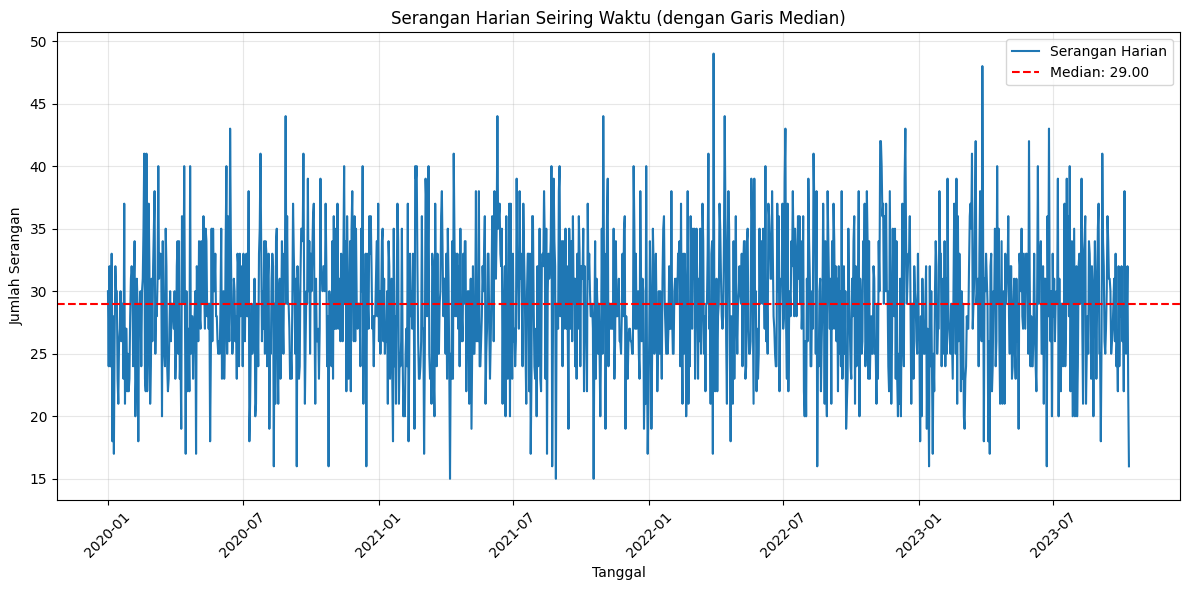

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_attacks_per_day_cleaned['Tanggal'], df_attacks_per_day_cleaned['jumlah'], label='Serangan Harian')
plt.axhline(y=df_attacks_per_day_cleaned['jumlah'].median(), color='r', linestyle='--',
            label=f'Median: {df_attacks_per_day_cleaned["jumlah"].median():.2f}')
plt.title("Serangan Harian Seiring Waktu (dengan Garis Median)")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Serangan")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45) # supaya ga ngelebar di sumbu x
plt.tight_layout()
plt.show()

## **Regresi Polinom (1-5) + Best Model**

Derajat 1: Korelasi = 0.0170, Adjusted R² = -0.0004
Derajat 2: Korelasi = 0.0584, Adjusted R² = 0.0020
Derajat 3: Korelasi = 0.0597, Adjusted R² = 0.0014
Derajat 4: Korelasi = 0.0691, Adjusted R² = 0.0019
Derajat 5: Korelasi = 0.0737, Adjusted R² = 0.0018


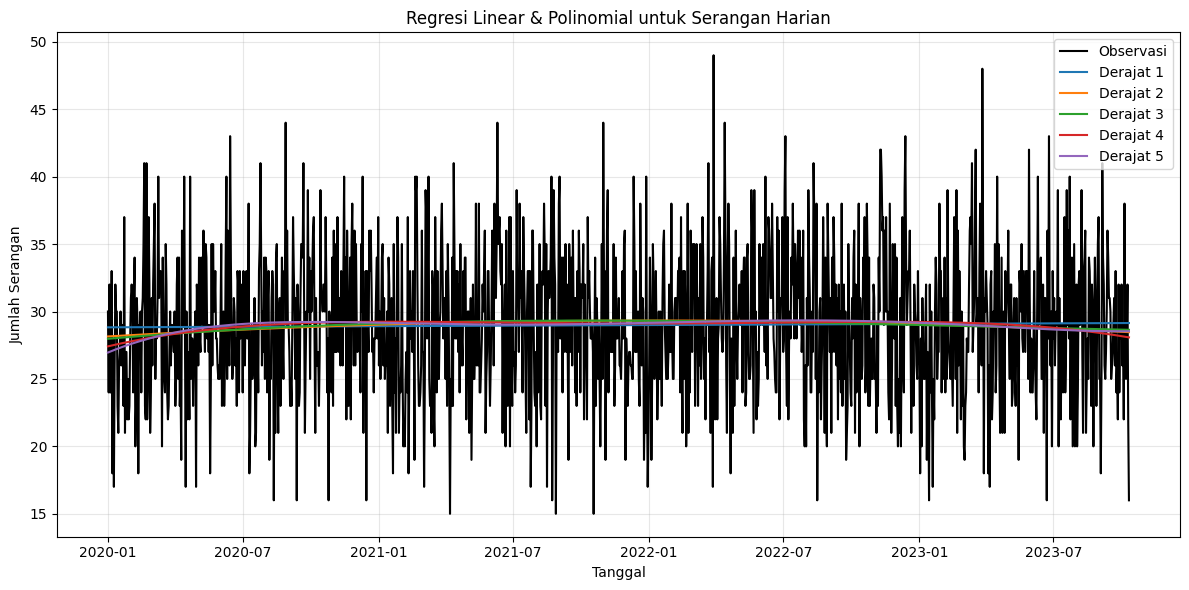


Model terbaik: Derajat 5 (Korelasi = 0.0737)



In [ ]:
# konversi tanggal ke urutan hari numerik (0=hari paling awal)
df_attacks_per_day_cleaned['HariNumerik'] = (
    df_attacks_per_day_cleaned['Tanggal'] - df_attacks_per_day_cleaned['Tanggal'].min()
).dt.days

x = df_attacks_per_day_cleaned['HariNumerik'] #urutan hari secara kontinu
y = df_attacks_per_day_cleaned['jumlah']

# plot observasi aktual
plt.figure(figsize=(12, 6))
plt.plot(df_attacks_per_day_cleaned['Tanggal'], y, label='Observasi', color='black')

# inisialisasi variable utnuk store model dengan best performance
best_correlation = -1
best_degree = 1
best_koefisien = None

for derajat in range(1, 6):
  koefisien = np.polyfit(x, y, derajat)
  y_pred = np.polyval(koefisien, x)

  korelasi, p_val = pearsonr(y, y_pred)

  # adjusted r² biar gak bias derajat tinggi
  ss_res = np.sum((y - y_pred)**2)
  ss_tot = np.sum((y - np.mean(y))**2)
  r2 = 1 - (ss_res / ss_tot)
  adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - derajat - 1)

  print(f"Derajat {derajat}: Korelasi = {korelasi:.4f}, Adjusted R² = {adj_r2:.4f}")

  if korelasi > best_correlation:
      best_correlation = korelasi
      best_degree = derajat
      best_koefisien = koefisien

  plt.plot(df_attacks_per_day_cleaned['Tanggal'], y_pred, label=f'Derajat {derajat}')

# plot hasil
plt.title("Regresi Linear & Polinomial untuk Serangan Harian")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Serangan")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nModel terbaik: Derajat {best_degree} (Korelasi = {best_correlation:.4f})\n")

## **PREDIKSI 30 HARI AHEAD**

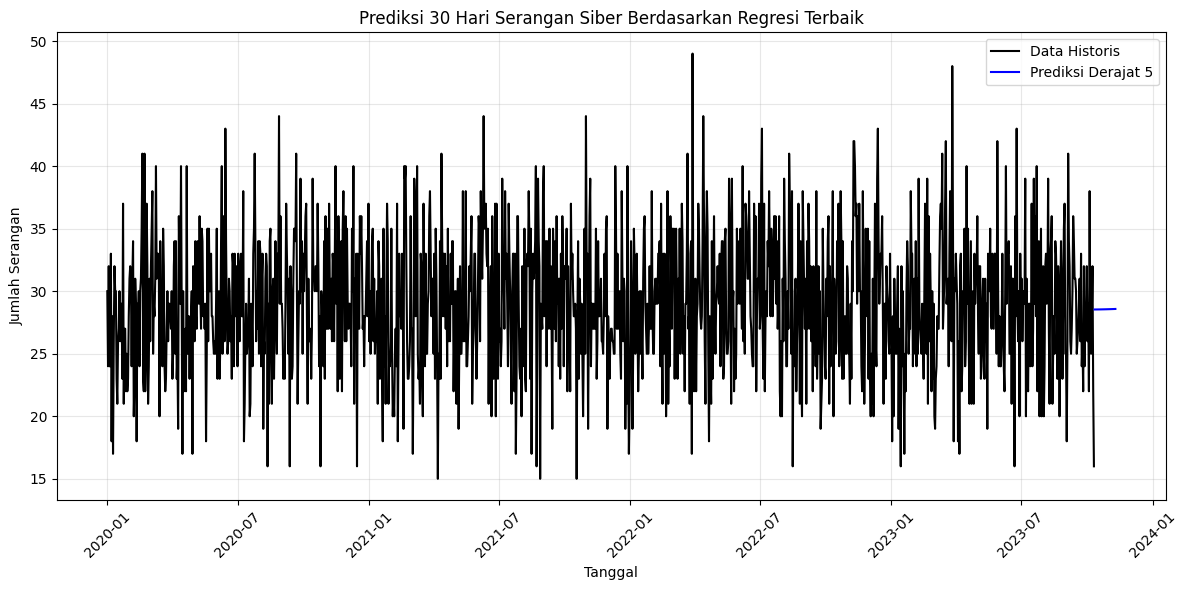

Prediksi 30 Hari ke Depan:
[28.53899118 28.53969479 28.54044871 28.54125339 28.54210922 28.54301666
 28.54397611 28.544988   28.54605278 28.54717086 28.54834268 28.54956868
 28.55084929 28.55218495 28.55357611 28.55502319 28.55652666 28.55808694
 28.55970449 28.56137976 28.56311319 28.56490524 28.56675636 28.56866702
 28.57063765 28.57266873 28.57476071 28.57691406 28.57912924 28.58140672]


In [ ]:
# buat urutan hari numerik baru (lanjutan dari existing data terakhir)
hari_masa_depan = np.arange(x.max() + 1, x.max() + 31)

# prediksi jumlah serangan untuk 30 hari ke depan dengan regresi terbaik
prediksi_masa_depan = np.polyval(best_koefisien, hari_masa_depan)

# ubah urutan hari jadi format tanggal aktual agar sejajar dengan timeline data historis
tanggal_masa_depan = df_attacks_per_day_cleaned['Tanggal'].max() + pd.to_timedelta(hari_masa_depan - x.max(), unit='D')

plt.figure(figsize=(12, 6))
plt.plot(df_attacks_per_day_cleaned['Tanggal'], y, label='Data Historis', color='black')
plt.plot(tanggal_masa_depan, prediksi_masa_depan, label=f'Prediksi Derajat {best_degree}', color='blue')
plt.title("Prediksi 30 Hari Serangan Siber Berdasarkan Regresi Terbaik")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Serangan")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Prediksi 30 Hari ke Depan:")
print(prediksi_masa_depan)